
# Entrenamiento de Modelos de Machine Learning para descripción de Nanopartículas Metálicas: 🌕🌟🌕

A continuación se realiza el procesamiento de datos de nanoparticulas metalicas, en principio compuestas por atomos de oro, para luego entrenar modelos de machine learning capaces de predecir la energía por átomo que tendrá cada nanoparticula.

En la primera entrega se realizó un analisis exploratorio de datos, en el cual se analizó en detalle los errores y outliers, las correlaciones, la variable objetivo y las variables relacionadas con esta, las cuales daban información importante sobre la estructura de las particulas analizadas. 

A continuación se realiza una limpieza extra de los datos, un escalamiento y además un PCA y clustering, previo al entrenamiento de los distintos modelos de regresión los cuales serán capaces de posteriormente predecir la energía de cualquier nanopartícula metálica.

# Importación de herramientas

In [63]:
# import warnings
# warnings.filterwarnings('ignore')

# from utils.path import *
# from utils.librerias import * 
# from utils.funciones import *


---
---
Como no me funciona esto de ir refrescando las utils, y tengo que reiniciar el kernel.
Hago aca secciones de lo que luego irá a distintos ficheros

### ${\textcolor{red}{\text{librerias}}}$ 

In [1]:
import warnings
warnings.filterwarnings('ignore')
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = ('ignore::UserWarning,ignore::ConvergenceWarning,ignore::RuntimeWarning, ignore::FutureWarning')

In [2]:
import os 
import warnings
warnings.filterwarnings('ignore')
import datetime as dt
import random
import pickle
import json
import csv
import re


import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import scipy.stats as ss

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from sklearn.linear_model import LinearRegression 

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_squared_log_error, mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV, RepeatedKFold

from sklearn.linear_model import LinearRegression, Ridge, Lasso, BayesianRidge, ElasticNet
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor,  GradientBoostingRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor


from yellowbrick.regressor import PredictionError, residuals_plot
from yellowbrick.model_selection import LearningCurve


### ${\textcolor{red}{\text{paths}}}$ 

In [3]:
###################################################################

DataAu = R'data/raw/Au_nanoparticle_dataset.csv'

### ${\textcolor{red}{\text{funciones}}}$ 

In [4]:
def missing_report(df):
        '''
        Pequeño reporte de los % de missings de cada columna del dataframe

                Parámetros:
                        df: (pd.DataFrame) dataset, que se analizará
                Returns:
                        (pd.DataFrame) con información calculada
        '''
        precent_missing = df.isnull().sum()*100/len(df)
        missing_value_df = pd.DataFrame({'column_name': df.columns,
                                'percent_missing': precent_missing}).sort_values('percent_missing', ascending=False)
        return missing_value_df

In [5]:
def zeros_report(df):
    '''
        Pequeño reporte de los % de zeros de cada columna del dataframe

                Parámetros:
                        df: (pd.DataFrame) dataset, que se analizará
                Returns:
                        (pd.DataFrame) con información calculada
    '''
    precent_zeros = (df==0).sum()*100/len(df)
    zeros_value_df = pd.DataFrame({'column_name': df.columns,
                                'percent_zeros': precent_zeros}).sort_values('percent_zeros', ascending=False)
    
    with pd.option_context("display.max_rows", None):
        display(zeros_value_df) 
    cols_to_drop = zeros_value_df[zeros_value_df['percent_zeros'] > 60].index.values
    print("Columnas con más del 60 porciento de valores igual a cero:", cols_to_drop)

In [6]:
def del_zeros(df):
    '''
    Eliminación de variables que contienen más de 60 porciento de valores igual a cero.

            Parámetros:
                    df: (pd.DataFrame) dataset que se desea limpiar 
            Returns:
                    nombre de las variables eliminadas.
                    cantidad de filas antes y despues de la limpieza
    '''
    precent_zeros = (df==0).sum()*100/len(df)
    zeros_value_df = pd.DataFrame({'column_name': df.columns,
                                'percent_zeros': precent_zeros}).sort_values('percent_zeros', ascending=False)
    cols_to_drop = zeros_value_df[zeros_value_df['percent_zeros'] > 60].index.values
    print("Cols:", cols_to_drop)

    print("Columnas pre drop:", len(df.columns))

    df.drop(columns=cols_to_drop, inplace=True)

    print("Columnas post drop:", len(df.columns))

In [7]:
def modeling(model, parameters, df_train_scaled_pca_cluster, n_clusters, dict_models):

    for i in range(n_clusters):
        df=df_train_scaled_pca_cluster[df_train_scaled_pca_cluster["Cluster"]==i].drop(columns="Cluster")

        cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=123)

        modelo_grid = GridSearchCV(estimator= model, 
        param_grid = parameters,
        scoring = "r2", 
        cv = cv, n_jobs= -1, verbose=0)

        start = dt.datetime.now()

        model_fit = modelo_grid.fit(df.drop(columns="target"), df["target"])

        dict_models[f"{model.__class__.__name__}_cluster_"+str(i)] = model_fit


        print(f'{model.__class__.__name__}_cluster_{i} :')
        print('\t Best Hyperparameters: %s' % model_fit.best_params_)
        print('\t Best Score: %s' % model_fit.best_score_)
        
        train_time = (dt.datetime.now() - start).seconds
        print("\t Training time: %0.3fs" % train_time)

    with open(f"utils/pickle/models/{model.__class__.__name__}_entrenados.pkl", "wb") as file:
        pickle.dump(dict_models, file)

In [8]:
def get_key(dicc, val):
    for key, value in dicc.items():
         if val == value:
             return key
 
    return "No está ese valor"

### ${\textcolor{red}{\text{dict de modelos}}}$ 

In [9]:
parameters_linear_regression = {'copy_X' : [True, False],
                                'fit_intercept' : [True, False]
                                }


parameters_Ridge = {'alpha': [0.1, 0.5, 1.0] ,
                    'fit_intercept': [True, False],
                    'max_iter': [100,1000],
                    'solver': ['auto', 'svd', 'cholesky'],
                    'random_state' : [0 , 1]
                    }


parameters_KernelRidge = {'kernel': ['polynomial', 'rbf'],
                        'alpha': [0.1, 0.5, 1 ] ,
                        'gamma': [0.01, 0.1] ,
                        'degree': [3, 2, 1] 
                        }


parameters_Lasso = {'alpha': [0.01, 1.0],
                    'copy_X': [True,False],
                    'fit_intercept': [True,False],
                    'max_iter': [100, 500, 1000],
                    'positive':[True,False],
                    'precompute': [True,False],
                    'selection': ['cyclic', 'random'],
                    'tol': [0.001, 0.01, 1],
                    'warm_start': [True,False]
                    }

parameters_ElasticNet = {'alpha': [0.01, 1.0],
                        'copy_X': [True,False],
                        'fit_intercept': [True,False],
                        'l1_ratio': [0, 0.5],
                        'max_iter': [100, 500, 1000],
                        'precompute': [True,False],
                        'random_state': [None, 0],
                        'tol': [0.0001, 0.01]
                        }  

parameters_DecisionTreeRegressor = {"splitter":["best","random"],
                                    "max_depth" : [1,3,5,7,9,11,12],
                                    "min_samples_leaf":[1,2,7,8,9,10],
                                    "min_weight_fraction_leaf":[0.1,0.2,0.5,0.7,0.8],
                                    "max_features":["auto","log2","sqrt",None],
                                    "max_leaf_nodes":[None,10,20,40,50,60] }
                        

parameters_AdaBoostRegressor = {'learning_rate': [0.01, 0.1, 1.0],
                                'loss': ['linear', 'exponential', 'square'],
                                'n_estimators': [50, 100, 500, 1000],
                                } 
 


parameters_GradientBoostingRegressor = {'alpha': [0.1, 0.9, 1],
                                        'learning_rate': [0.05, 0.1],
                                        'loss': ['squared_error','huber'],
                                        'max_depth': [1, 3],
                                        'min_samples_split': [2, 3],
                                        'n_estimators': [100, 500],
                                    }   

parameters_RandomForestRegressor = {'bootstrap': [True,False],
                                    'n_estimators': [10,50,100,500],
                                    'max_depth':[None ,10, 50, 100 ],               
                                    'min_samples_leaf': [1, 2],
                                    'random_state': [None, 0],
                                    }


parameters_ExtraTrees = {'ccp_alpha' : [0.0 ,0.1, 0.5],
                        'min_samples_leaf': [1, 2],
                        'min_samples_split' : [2, 3, 5]
                        }      

parameters_KNeighborsRegressor = {'algorithm': ['auto', 'ball_tree', 'kd_tree'],
                                'leaf_size': [2, 5, 30],
                                'n_neighbors': [5, 6, 10, 14]
                                }                    
                      

params_BaggingRegressor = {'n_estimators' : [10, 50,100],
                'max_features' :[1,2,4,6,8],
                'max_samples' : [0.5,0.1, 1.0],
                'bootstrap' : [True, False]
                }

parameters_SVR = {'C': [0.1, 1.0],
                'degree': [1, 3],
                'gamma': ['scale',10.0, 100.0],
                'kernel': ['rbf', 'poly', 'sigmoid'],
                'shrinking': [True,False]
                }   

In [10]:
models = { 
"LinearRegression" :  [LinearRegression(), parameters_linear_regression],

"Ridge" : [Ridge(), parameters_Ridge],

"Lasso" : [Lasso(), parameters_Lasso],

"ElasticNet" : [ElasticNet(), parameters_ElasticNet],

"KernelRidge" : [KernelRidge(), parameters_KernelRidge],

"DecisionTreeRegressor" : [DecisionTreeRegressor(), parameters_DecisionTreeRegressor],

"ExtraTreeRegressor" : [ExtraTreeRegressor(), parameters_ExtraTrees],

"RandomForestRegressor" : [RandomForestRegressor(), parameters_RandomForestRegressor],

"KNeighborsRegressor" : [KNeighborsRegressor(), parameters_KNeighborsRegressor], 

"GradientBoostingRegressor" : [GradientBoostingRegressor(), parameters_GradientBoostingRegressor],

"AdaBoostRegressor" : [AdaBoostRegressor(), parameters_AdaBoostRegressor],

"BaggingRegressor" : [BaggingRegressor(), params_BaggingRegressor],

"SVR" : [SVR(), parameters_SVR]

}

---
---

# Lectura base de datos

Base de datos de 4000 nanopartículas de 236 hasta 14277 átomos, generadas mediante dinámica molecular a una variedad de temperaturas, tasas de crecimiento y tiempos, y está disponible para su [descarga gratuita](https://data.csiro.au/collection/csiro:40669). Las condiciones de síntesis no se han utilizado como características en cada experimento. La energía total de la nanoparticula se asignará como variable objetivo.


In [11]:
data = pd.read_csv(DataAu)

In [12]:
data

,ID,T,tau,time,N_total,N_bulk,N_surface,Volume,R_min,R_max,...,q6q6_S14,q6q6_S15,q6q6_S16,q6q6_S17,q6q6_S18,q6q6_S19,q6q6_S20,q6q6_S20+,Total_E,Formation_E
0,1,273,0.000025,1,1599,1014,585,2.710000e-26,15.5898,19.4516,...,0,0,0,0,0,0,0,0,-5908.6345,343.4555
1,2,273,0.000025,2,1642,1034,608,2.780000e-26,15.3996,24.1755,...,0,0,0,0,0,0,0,0,-6035.4034,384.8166
2,3,273,0.000025,3,4637,3365,1272,7.850000e-26,21.9199,31.0305,...,0,0,0,0,0,0,0,0,-17330.1660,800.5040
3,4,273,0.000025,4,7189,5292,1897,1.220000e-25,23.2542,37.8795,...,0,0,0,0,0,0,0,0,-26937.2010,1171.7890
4,5,273,0.000025,5,11004,8508,2496,1.860000e-25,27.1200,39.7614,...,0,0,0,0,0,0,0,0,-41427.9010,1597.7390
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,3996,973,0.000250,6,1509,950,559,2.550000e-26,13.8048,23.1729,...,0,0,0,0,0,0,0,0,-5346.9589,553.2311
3996,3997,973,0.000250,7,2315,1469,846,3.920000e-26,12.0020,36.7573,...,0,0,0,0,0,0,0,0,-8218.1252,833.5248
3997,3998,973,0.000250,8,2764,1905,859,4.680000e-26,18.8611,24.6101,...,0,0,0,0,0,0,0,0,-9876.2899,930.9501
3998,3999,973,0.000250,9,3148,2199,949,5.330000e-26,18.7624,26.0008,...,0,0,0,0,0,0,0,0,-11261.0810,1047.5990


Se cuenta con 185 columnas. De las cuales una es una ID de identificación, que pasará a ser indice, luego 183 carateristicas de las nanoparticulas y de su formación

In [13]:
data= data.drop('ID', axis=1)

no hay variables categoricas, como ya que se hizo una pre limpieza en la primera entrega

In [14]:
len(data.columns[data.dtypes == "object"].tolist())

0

Se comprueba que no hayan quedados valores nulos

In [15]:
missing_report(data)

,column_name,percent_missing
Formation_E,Formation_E,0.025
q6q6_T10,q6q6_T10,0.000
q6q6_T1,q6q6_T1,0.000
q6q6_T2,q6q6_T2,0.000
q6q6_T3,q6q6_T3,0.000
...,...,...
BCN_3,BCN_3,0.000
BCN_4,BCN_4,0.000
BCN_5,BCN_5,0.000
BCN_6,BCN_6,0.000


Se observa que solo la energía de formación cuanta con un 2.5% de valores nulos. Se analizá si las entradas que cuentan con estos valores son relevantes 

In [16]:
data[data['Formation_E'].isna()]

,T,tau,time,N_total,N_bulk,N_surface,Volume,R_min,R_max,R_diff,...,q6q6_S14,q6q6_S15,q6q6_S16,q6q6_S17,q6q6_S18,q6q6_S19,q6q6_S20,q6q6_S20+,Total_E,Formation_E
3999,973,0.00025,10,3986,2785,1201,6.750000e-26,19.1334,44.7678,25.6344,...,0,0,0,0,0,0,0,0,-14264.397,NaN


Es solo la ultima entrada (de 4000) por lo que se procede a su eliminación

In [17]:
data.drop(data.tail(1).index, inplace = True) 

## Features con ceros

Por conocimiento previo de los datos, se sabe que hay variables que cuantan con un alto porcentaje de ceros, las cuales se vuelven irrelevantes a la hora de entrenar modelos de predicción. Se realiza un reporte de estas variables.

In [18]:
zeros_report(data)

,column_name,percent_zeros
q6q6_B20+,q6q6_B20+,100.000000
SCN_16,SCN_16,100.000000
Curve_141-150,Curve_141-150,100.000000
Curve_151-160,Curve_151-160,100.000000
Curve_161-170,Curve_161-170,100.000000
Curve_171-180,Curve_171-180,100.000000
TCN_0,TCN_0,100.000000
q6q6_B19,q6q6_B19,100.000000
q6q6_B16,q6q6_B16,100.000000
q6q6_B17,q6q6_B17,100.000000


Columnas con más del 60 porciento de valores igual a cero: ['q6q6_B20+' 'SCN_16' 'Curve_141-150' 'Curve_151-160' 'Curve_161-170'
 'Curve_171-180' 'TCN_0' 'q6q6_B19' 'q6q6_B16' 'q6q6_B17' 'SCN_20'
 'SCN_19' 'SCN_18' 'SCN_17' 'TCN_18' 'Curve_121-130' 'TCN_19' 'TCN_20'
 'BCN_0' 'BCN_1' 'BCN_2' 'BCN_3' 'BCN_4' 'q6q6_B20' 'BCN_18' 'BCN_19'
 'BCN_20' 'SCN_0' 'Curve_131-140' 'q6q6_B18' 'Curve_111-120' 'q6q6_T19'
 'q6q6_T17' 'q6q6_T16' 'q6q6_T20' 'q6q6_T20+' 'q6q6_S20+' 'q6q6_S20'
 'Curve_101-110' 'q6q6_S14' 'q6q6_S15' 'q6q6_S16' 'q6q6_S17' 'q6q6_S19'
 'q6q6_S18' 'Curve_81-90' 'Curve_91-100' 'q6q6_T18' 'TCN_17' 'BCN_5'
 'SCN_15' 'BCN_17' 'BCN_6' 'q6q6_B15' 'q6q6_T15' 'BCN_7' 'SCN_14'
 'q6q6_S13' 'ICOS' 'BCN_16' 'TCN_16' 'Curve_71-80' 'TCN_1' 'SCN_1' 'SCN_2'
 'TCN_2' 'BCN_8' 'SCN_3' 'TCN_3' 'BCN_9' 'q6q6_S12' 'SCN_13' 'tau']


Luego de analizar el significado físico de las variables (ver lista de descrición en [memoria EDA](https://github.com/JosefinaCresta/EDA_NanoparticulasAu_TBDS/blob/master/EDA_NanoparticulasAu_Memoria.pdf=), y comprender que dichos valores ceros, se deben a que dichas caracteristicas son irrelavantes en la descripción de las nanoparticulas de los tamaños estudiado,  se procede a la eliminación de las columnas con más del 60% de ceros.

In [19]:
del_zeros(data)

Cols: ['q6q6_B20+' 'SCN_16' 'Curve_141-150' 'Curve_151-160' 'Curve_161-170'
 'Curve_171-180' 'TCN_0' 'q6q6_B19' 'q6q6_B16' 'q6q6_B17' 'SCN_20'
 'SCN_19' 'SCN_18' 'SCN_17' 'TCN_18' 'Curve_121-130' 'TCN_19' 'TCN_20'
 'BCN_0' 'BCN_1' 'BCN_2' 'BCN_3' 'BCN_4' 'q6q6_B20' 'BCN_18' 'BCN_19'
 'BCN_20' 'SCN_0' 'Curve_131-140' 'q6q6_B18' 'Curve_111-120' 'q6q6_T19'
 'q6q6_T17' 'q6q6_T16' 'q6q6_T20' 'q6q6_T20+' 'q6q6_S20+' 'q6q6_S20'
 'Curve_101-110' 'q6q6_S14' 'q6q6_S15' 'q6q6_S16' 'q6q6_S17' 'q6q6_S19'
 'q6q6_S18' 'Curve_81-90' 'Curve_91-100' 'q6q6_T18' 'TCN_17' 'BCN_5'
 'SCN_15' 'BCN_17' 'BCN_6' 'q6q6_B15' 'q6q6_T15' 'BCN_7' 'SCN_14'
 'q6q6_S13' 'ICOS' 'BCN_16' 'TCN_16' 'Curve_71-80' 'TCN_1' 'SCN_1' 'SCN_2'
 'TCN_2' 'BCN_8' 'SCN_3' 'TCN_3' 'BCN_9' 'q6q6_S12' 'SCN_13' 'tau']
Columnas pre drop: 184
Columnas post drop: 111


In [20]:
data.head(10)

,T,time,N_total,N_bulk,N_surface,Volume,R_min,R_max,R_diff,R_avg,...,q6q6_S4,q6q6_S5,q6q6_S6,q6q6_S7,q6q6_S8,q6q6_S9,q6q6_S10,q6q6_S11,Total_E,Formation_E
0,273,1,1599,1014,585,2.710000e-26,15.5898,19.4516,3.8618,17.3706,...,33,25,18,18,13,18,1,0,-5908.6345,343.4555
1,273,2,1642,1034,608,2.780000e-26,15.3996,24.1755,8.7760,17.6061,...,32,26,26,6,15,12,2,0,-6035.4034,384.8166
2,273,3,4637,3365,1272,7.850000e-26,21.9199,31.0305,9.1106,25.3692,...,95,99,117,123,99,116,51,17,-17330.1660,800.5040
3,273,4,7189,5292,1897,1.220000e-25,23.2542,37.8795,14.6253,29.7011,...,135,147,188,214,227,227,121,64,-26937.2010,1171.7890
4,273,5,11004,8508,2496,1.860000e-25,27.1200,39.7614,12.6415,34.2831,...,154,190,281,308,287,320,156,74,-41427.9010,1597.7390
5,273,6,13375,10768,2607,2.260000e-25,33.2496,42.9612,9.7116,36.6334,...,137,203,304,382,324,435,248,143,-50687.6660,1608.5840
6,273,7,13795,11155,2640,2.340000e-25,33.6164,41.6168,8.0004,37.0108,...,117,210,297,427,375,463,269,188,-52334.7900,1603.6600
7,273,8,13947,11304,2643,2.360000e-25,34.5185,41.4386,6.9201,37.1672,...,136,166,345,416,376,481,268,181,-52912.3150,1620.4550
8,273,9,14020,11357,2663,2.370000e-25,34.7525,41.5998,6.8473,37.2103,...,118,176,319,443,374,472,279,181,-53212.1320,1606.0680
9,273,10,14056,11389,2667,2.380000e-25,34.7870,41.5401,6.7531,37.2467,...,105,211,301,415,385,481,274,190,-53347.8030,1611.1570


Por ultimo se nota (y averigua con los físicos experimentales que recolectaron la información) que la columna tiempo, no se refiera al tiempo de creación de la nanoparticula, sino que fue una etiqueta del momento de lectura de las caractiristcas. Lo cual se puede observar a continuación, que es una etiqueta del 1 al 10, ya que cada simulación con dinamica molecular arrojaba 10 nanoparticulas. Por lo tanto no tiene relevancia fisica en la informacion estructural ni energitica de la nanoparticula, por lo cual se procede a su eliminación

In [21]:
with pd.option_context("display.max_rows", None):
        display(data["time"]) 

0        1
1        2
2        3
3        4
4        5
5        6
6        7
7        8
8        9
9       10
10       1
11       2
12       3
13       4
14       5
15       6
16       7
17       8
18       9
19      10
20       1
21       2
22       3
23       4
24       5
25       6
26       7
27       8
28       9
29      10
30       1
31       2
32       3
33       4
34       5
35       6
36       7
37       8
38       9
39      10
40       1
41       2
42       3
43       4
44       5
45       6
46       7
47       8
48       9
49      10
50       1
51       2
52       3
53       4
54       5
55       6
56       7
57       8
58       9
59      10
60       1
61       2
62       3
63       4
64       5
65       6
66       7
67       8
68       9
69      10
70       1
71       2
72       3
73       4
74       5
75       6
76       7
77       8
78       9
79      10
80       1
81       2
82       3
83       4
84       5
85       6
86       7
87       8
88       9
89      10
90       1

In [22]:
data = data.drop("time", axis=1)

Por último, como la energía total de la nanoparticula está estrictamente relacionada con la cantidad de átomos que la forman (analizado en el [EDA](https://github.com/JosefinaCresta/EDA_NanoparticulasAu_TBDS/blob/master/src/EDA.ipynb)). Se calcula la energía por átomo ("E_atom") de cada particula y esa será la variable target de los futuros modelos

In [23]:
data["E_atom"] = data["Total_E"]/data["N_total"]
data = data.drop("Total_E", axis=1)

In [24]:
data

,T,N_total,N_bulk,N_surface,Volume,R_min,R_max,R_diff,R_avg,R_std,...,q6q6_S4,q6q6_S5,q6q6_S6,q6q6_S7,q6q6_S8,q6q6_S9,q6q6_S10,q6q6_S11,Formation_E,E_atom
0,273,1599,1014,585,2.710000e-26,15.5898,19.4516,3.8618,17.3706,0.6230,...,33,25,18,18,13,18,1,0,343.4555,-3.695206
1,273,1642,1034,608,2.780000e-26,15.3996,24.1755,8.7760,17.6061,0.9295,...,32,26,26,6,15,12,2,0,384.8166,-3.675642
2,273,4637,3365,1272,7.850000e-26,21.9199,31.0305,9.1106,25.3692,1.0701,...,95,99,117,123,99,116,51,17,800.5040,-3.737366
3,273,7189,5292,1897,1.220000e-25,23.2542,37.8795,14.6253,29.7011,2.3732,...,135,147,188,214,227,227,121,64,1171.7890,-3.747003
4,273,11004,8508,2496,1.860000e-25,27.1200,39.7614,12.6415,34.2831,1.9397,...,154,190,281,308,287,320,156,74,1597.7390,-3.764804
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3994,973,1201,683,518,2.030000e-26,11.7580,31.2844,19.5264,16.7874,3.6921,...,2,0,0,0,0,0,0,0,465.3670,-3.522517
3995,973,1509,950,559,2.550000e-26,13.8048,23.1729,9.3681,17.4079,1.5120,...,3,0,0,1,0,0,0,0,553.2311,-3.543379
3996,973,2315,1469,846,3.920000e-26,12.0020,36.7573,24.7553,21.2937,4.8536,...,4,0,0,0,0,0,0,0,833.5248,-3.549946
3997,973,2764,1905,859,4.680000e-26,18.8611,24.6101,5.7490,21.4990,1.0829,...,10,4,0,1,0,0,0,0,930.9501,-3.573187


Se guarda el DataFrame antes de aplicarle escalado, reducción de dimensionalidad etc

In [25]:
data.to_csv("data/processed/data_clear.csv",index=False)

In [26]:
df = pd.read_csv("data/processed/data_clear.csv")

In [27]:
df

,T,N_total,N_bulk,N_surface,Volume,R_min,R_max,R_diff,R_avg,R_std,...,q6q6_S4,q6q6_S5,q6q6_S6,q6q6_S7,q6q6_S8,q6q6_S9,q6q6_S10,q6q6_S11,Formation_E,E_atom
0,273,1599,1014,585,2.710000e-26,15.5898,19.4516,3.8618,17.3706,0.6230,...,33,25,18,18,13,18,1,0,343.4555,-3.695206
1,273,1642,1034,608,2.780000e-26,15.3996,24.1755,8.7760,17.6061,0.9295,...,32,26,26,6,15,12,2,0,384.8166,-3.675642
2,273,4637,3365,1272,7.850000e-26,21.9199,31.0305,9.1106,25.3692,1.0701,...,95,99,117,123,99,116,51,17,800.5040,-3.737366
3,273,7189,5292,1897,1.220000e-25,23.2542,37.8795,14.6253,29.7011,2.3732,...,135,147,188,214,227,227,121,64,1171.7890,-3.747003
4,273,11004,8508,2496,1.860000e-25,27.1200,39.7614,12.6415,34.2831,1.9397,...,154,190,281,308,287,320,156,74,1597.7390,-3.764804
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3994,973,1201,683,518,2.030000e-26,11.7580,31.2844,19.5264,16.7874,3.6921,...,2,0,0,0,0,0,0,0,465.3670,-3.522517
3995,973,1509,950,559,2.550000e-26,13.8048,23.1729,9.3681,17.4079,1.5120,...,3,0,0,1,0,0,0,0,553.2311,-3.543379
3996,973,2315,1469,846,3.920000e-26,12.0020,36.7573,24.7553,21.2937,4.8536,...,4,0,0,0,0,0,0,0,833.5248,-3.549946
3997,973,2764,1905,859,4.680000e-26,18.8611,24.6101,5.7490,21.4990,1.0829,...,10,4,0,1,0,0,0,0,930.9501,-3.573187


## Separación datos de entrenamiento y prueba para los modelos de regresión

se toma un 70% de la base de datos para el entrenamiento y el 30% restante servirán para el testeo

In [28]:
train, test = train_test_split(df, test_size=0.3, random_state=1234)

In [29]:
train.shape

(2799, 110)

In [30]:
train.head(1)

,T,N_total,N_bulk,N_surface,Volume,R_min,R_max,R_diff,R_avg,R_std,...,q6q6_S4,q6q6_S5,q6q6_S6,q6q6_S7,q6q6_S8,q6q6_S9,q6q6_S10,q6q6_S11,Formation_E,E_atom
2840,723,1052,608,444,1.780000e-26,11.3213,21.2488,9.9275,15.1935,1.2668,...,10,4,0,0,1,0,0,0,368.5927,-3.559627


In [31]:
test.shape

(1200, 110)

In [32]:
test.head(1)

,T,N_total,N_bulk,N_surface,Volume,R_min,R_max,R_diff,R_avg,R_std,...,q6q6_S4,q6q6_S5,q6q6_S6,q6q6_S7,q6q6_S8,q6q6_S9,q6q6_S10,q6q6_S11,Formation_E,E_atom
268,323,501,251,250,8.480000e-27,10.0965,12.7546,2.658,11.3813,0.7484,...,7,7,55,44,51,38,7,32,157.1922,-3.596243


Reinicio de los indices

In [33]:
train.reset_index(drop=True,inplace=True)
test.reset_index(drop=True,inplace=True)

In [34]:
train

,T,N_total,N_bulk,N_surface,Volume,R_min,R_max,R_diff,R_avg,R_std,...,q6q6_S4,q6q6_S5,q6q6_S6,q6q6_S7,q6q6_S8,q6q6_S9,q6q6_S10,q6q6_S11,Formation_E,E_atom
0,723,1052,608,444,1.780000e-26,11.3213,21.2488,9.9275,15.1935,1.2668,...,10,4,0,0,1,0,0,0,368.5927,-3.559627
1,623,6638,4708,1930,1.120000e-25,14.6557,40.9135,26.2577,29.0740,4.1762,...,150,139,191,215,180,233,86,43,1380.9320,-3.701966
2,523,2255,1469,786,3.820000e-26,16.2709,27.2866,11.0158,19.9620,2.3369,...,4,4,16,93,51,557,54,0,587.9203,-3.649281
3,473,1624,984,640,2.750000e-26,12.5501,24.0010,11.4509,17.7143,2.3724,...,41,54,75,101,71,81,26,10,383.9068,-3.673604
4,523,598,275,323,1.010000e-26,7.8226,19.6323,11.8098,12.6550,2.6410,...,17,12,19,47,32,145,9,0,218.2515,-3.545031
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2794,923,538,275,263,9.110000e-27,9.3572,14.2842,4.9270,11.8698,0.9227,...,5,4,2,0,0,1,0,0,283.6284,-3.382810
2795,873,8901,6951,1950,1.510000e-25,27.1028,37.7048,10.6019,32.3480,1.5531,...,22,9,4,0,0,0,0,0,2488.9900,-3.630370
2796,523,718,371,347,1.220000e-26,10.4473,16.7356,6.2883,13.0708,1.4231,...,8,16,30,51,35,154,26,10,245.7666,-3.567707
2797,323,5366,3760,1606,9.080000e-26,23.1172,33.7459,10.6288,26.5416,1.8914,...,10,35,70,619,95,82,88,573,1006.2150,-3.722483


In [35]:
test

,T,N_total,N_bulk,N_surface,Volume,R_min,R_max,R_diff,R_avg,R_std,...,q6q6_S4,q6q6_S5,q6q6_S6,q6q6_S7,q6q6_S8,q6q6_S9,q6q6_S10,q6q6_S11,Formation_E,E_atom
0,323,501,251,250,8.480000e-27,10.0965,12.7546,2.6580,11.3813,0.7484,...,7,7,55,44,51,38,7,32,157.1922,-3.596243
1,923,653,351,302,1.110000e-26,10.2648,14.8840,4.6192,12.7802,0.8892,...,3,0,0,0,0,0,0,0,338.2439,-3.392015
2,923,1834,1186,648,3.100000e-26,15.0151,24.1225,9.1074,18.4972,1.5591,...,39,51,53,69,80,161,19,3,715.6960,-3.519762
3,523,2190,1493,697,3.710000e-26,16.2145,23.7463,7.5318,19.7146,2.0745,...,17,24,47,104,168,292,18,0,581.4362,-3.644504
4,923,5127,3817,1310,8.680000e-26,23.4245,29.4661,6.0417,26.5250,1.0806,...,113,101,114,109,100,104,18,5,1835.5730,-3.551979
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,323,1342,810,532,2.270000e-26,12.6741,21.7786,9.1045,16.7708,2.6606,...,10,6,31,60,74,326,21,0,314.8300,-3.675402
1196,723,1484,950,534,2.510000e-26,14.9522,19.6956,4.7433,17.0700,1.0710,...,28,36,60,81,80,122,14,0,507.4801,-3.568032
1197,923,499,248,251,8.450000e-27,8.8122,14.1421,5.3299,11.5638,0.9037,...,2,0,0,0,0,0,0,0,262.9603,-3.383025
1198,573,7624,5552,2072,1.290000e-25,19.1639,39.8695,20.7056,30.4217,3.6245,...,137,156,216,243,227,329,128,54,1449.6160,-3.719861


In [36]:
train.to_csv("data/processed/train_clear.csv",index=False)
test.to_csv("data/processed/test_clear.csv",index=False)

# Normalización de los datos

Como se trata de un problema de regresión, es deseable escalar o transformar tanto las variables de entrada como las de destino. 

Se utiliza `StandardScaler` el cual estandariza una característica restando la media y luego escalando de forma que su varianza sea igual a 1. La varianza unitaria significa dividir todos los valores por la desviación estándar.

In [37]:
scaler=StandardScaler()
x_train=train.drop(["E_atom"], axis=1)
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)

In [38]:
pd.DataFrame(x_train_scaled, columns=x_train.columns)

,T,N_total,N_bulk,N_surface,Volume,R_min,R_max,R_diff,R_avg,R_std,...,q6q6_S3,q6q6_S4,q6q6_S5,q6q6_S6,q6q6_S7,q6q6_S8,q6q6_S9,q6q6_S10,q6q6_S11,Formation_E
0,0.480306,-0.658597,-0.642763,-0.706392,-0.658760,-0.762960,-0.477831,0.067491,-0.716243,-0.419325,...,-0.616705,-0.658568,-0.745722,-0.832639,-0.825508,-0.758089,-0.662655,-0.626617,-0.356174,-0.625338
1,0.034321,0.862835,0.738409,1.351732,0.857146,-0.267089,1.515375,2.715759,1.109302,2.048138,...,2.184713,2.429055,1.635200,1.457440,0.922917,0.729692,0.268985,0.589788,0.178167,0.689741
2,-0.411664,-0.330942,-0.352717,-0.232719,-0.330475,-0.026886,0.134158,0.243981,-0.089096,0.488227,...,-0.871380,-0.790895,-0.745722,-0.640800,-0.069212,-0.342508,1.564485,0.137172,-0.356174,-0.340421
3,-0.634656,-0.502804,-0.516099,-0.434931,-0.502664,-0.580221,-0.198869,0.314541,-0.384710,0.518335,...,0.019981,0.025120,0.136101,0.066607,-0.004155,-0.176275,-0.338780,-0.258866,-0.231908,-0.605444
4,-0.411664,-0.782251,-0.754941,-0.873979,-0.782672,-1.283265,-0.641679,0.372744,-1.050103,0.746135,...,-0.718575,-0.504187,-0.604630,-0.604830,-0.443294,-0.500429,-0.082879,-0.499319,-0.356174,-0.820639
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2794,1.372277,-0.798593,-0.754941,-0.957079,-0.798603,-1.055049,-1.183760,-0.743440,-1.153371,-0.711157,...,-0.718575,-0.768841,-0.745722,-0.808659,-0.825508,-0.766401,-0.658657,-0.626617,-0.356174,-0.735711
2795,1.149284,1.479198,1.494010,1.379432,1.484750,1.583967,1.190142,0.176859,1.539894,-0.176514,...,0.249188,-0.393915,-0.657539,-0.784679,-0.825508,-0.766401,-0.662655,-0.626617,-0.356174,2.129163
2796,-0.411664,-0.749567,-0.722601,-0.840738,-0.748878,-0.892936,-0.935287,-0.522678,-0.995417,-0.286767,...,-0.820445,-0.702677,-0.534084,-0.472941,-0.410765,-0.475494,-0.046893,-0.258866,-0.231908,-0.784895
2797,-1.303634,0.516387,0.419055,0.902989,0.515986,0.991253,0.788870,0.181221,0.776244,0.110398,...,-0.769510,-0.658568,-0.198991,0.006657,4.208330,0.023204,-0.334782,0.618077,6.764224,0.202965


In [1]:
x_train_scaled.hist()

NameError: name 'x_train_scaled' is not defined

Se guarda el escalador para su posterior uso en la data de testeo y predicción

In [39]:
with open("utils/pickle/scaler.pkl", "wb") as file:
  pickle.dump(scaler, file)

# PCA

Debido a que se cuentan con más de 100 caracteristicas, se realiza un análisis de componentes principales (Principal Component Analysis PCA), el cual es un método de reducción de dimensionalidad que permite simplificar la complejidad de espacios con múltiples dimensiones, como el presente, a la vez que conserva su información. 

Se selecciona el número de componentes que explican el 99% de varianza y asi obtendremos buenas predicciones

In [40]:
pca = PCA(0.99) 
x_train_scaled_pca = pca.fit_transform(x_train_scaled) # fit PCA on training dataset only

In [41]:
pca.n_components_ 

26

Se grafica el acumulado de varianza explicada en las nuevas dimensiones

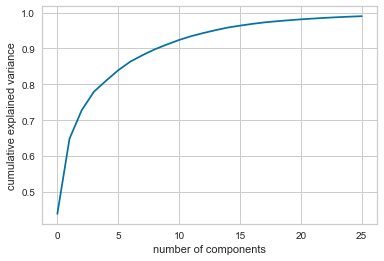

In [42]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

In [43]:
df_train_scaled_pca = pd.DataFrame(x_train_scaled_pca, columns=["Componente_"+str(i) for i in range(0, pca.n_components_ )])

In [44]:
df_train_scaled_pca.head()

,Componente_0,Componente_1,Componente_2,Componente_3,Componente_4,Componente_5,Componente_6,Componente_7,Componente_8,Componente_9,...,Componente_16,Componente_17,Componente_18,Componente_19,Componente_20,Componente_21,Componente_22,Componente_23,Componente_24,Componente_25
0,-4.442963,3.587511,-1.255582,0.604426,-2.379550,0.570928,-0.651487,0.636133,0.737203,1.040708,...,0.067294,-0.474344,0.237119,0.252372,0.714281,0.494828,0.146696,0.279184,-0.053842,-0.474012
1,8.768027,-2.008431,-1.927300,-0.096992,-1.655207,-1.699231,0.440580,-2.611777,-0.599534,-0.368511,...,-0.199294,0.275594,0.148512,-0.174904,0.024542,0.749605,-0.500706,-0.045889,0.388290,0.291508
2,-3.402397,-3.100224,3.054614,-2.653849,-0.068559,-1.486662,-1.853944,0.289215,-0.218145,0.061341,...,-0.455667,0.211053,-0.429589,0.028356,0.005476,-0.462021,0.076959,0.190722,-0.158671,0.099207
3,-2.350996,-1.289506,-1.098710,0.183329,0.309257,-1.191493,-0.128864,-0.471096,-0.035702,0.389723,...,-0.037945,-0.194999,-0.119351,0.459739,0.292559,-0.195490,0.194392,-0.048206,0.100788,0.113750
4,-5.887342,-1.178596,-0.134620,-0.429008,-0.053769,-1.595451,-0.093559,0.525134,0.056660,-0.230910,...,-0.545095,-1.235791,-1.156151,-0.232090,0.256800,-0.143513,0.481217,0.104821,0.109224,-0.103068


se guarda el pca

In [45]:
with open("utils/pickle/pca.pkl", "wb") as file:
  pickle.dump(pca, file)

# Clustering 

Por más que en la base de datos utilizada se cuenta con la variable objetivo (Energía), se realiza un algoritmo no supervisado de Clustering K-Means.  El objetivo de este algoritmo es el de encontrar “K” grupos (clusters) entre los datos crudos, ya que se cuenta con un amplio rango de tamaños (de 236 hasta 14277 átomos). El algoritmo trabaja iterativamente para asignar a cada “punto” (Nanoparticula) uno de los “K” grupos basado en sus características. Son agrupados en base a la similitud de sus caracteristicas.

Este algoritmo funciona pre-seleccionando un valor de K. Para encontrar el número de clusters en los datos, deberemos ejecutar el algoritmo para un rango de valores K, ver los resultados y comparar características de los grupos obtenidos. En general no hay un modo exacto de determinar el valor K, pero se puede estimar con aceptable precisión utilizando el método del codo

WCSS será la suma de la distancia al cuadrado entre cada punto y el centroide en un grupo. Se gráfica a continuación el WCSS contra el valor K:

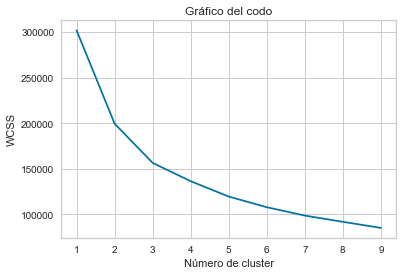

In [46]:
wcss = []
for i in range(1,10):
    kmeans=KMeans(n_clusters=i).fit(x_train_scaled_pca)
    wcss.append(kmeans.inertia_)
#Plotting The Elbow graph
plt.plot(range(1, 10), wcss)
plt.title('Gráfico del codo')
plt.xlabel('Número de cluster')
plt.ylabel('WCSS')
plt.show()

Al entontrar el “punto codo”, donde la tasa de descenso se “afila”, en 3, se escogen a continuación 3 cluster para la data estudiada.

In [47]:
knn_3 = KMeans(random_state=1234,n_clusters=3).fit(x_train_scaled_pca)

In [48]:
cluster_label = knn_3.predict(x_train_scaled_pca)

In [49]:
knn_3.labels_

array([0, 2, 0, ..., 0, 2, 0], dtype=int32)

In [50]:
df_train_scaled_pca_cluster = df_train_scaled_pca

In [51]:
df_train_scaled_pca_cluster ["Cluster"]= knn_3.labels_

se guarda el clustering

In [52]:
with open('utils/pickle/kmeans3.pkl',"wb") as file:
    pickle.dump(knn_3,file)

In [53]:
df_train_scaled_pca_cluster

,Componente_0,Componente_1,Componente_2,Componente_3,Componente_4,Componente_5,Componente_6,Componente_7,Componente_8,Componente_9,...,Componente_17,Componente_18,Componente_19,Componente_20,Componente_21,Componente_22,Componente_23,Componente_24,Componente_25,Cluster
0,-4.442963,3.587511,-1.255582,0.604426,-2.379550,0.570928,-0.651487,0.636133,0.737203,1.040708,...,-0.474344,0.237119,0.252372,0.714281,0.494828,0.146696,0.279184,-0.053842,-0.474012,0
1,8.768027,-2.008431,-1.927300,-0.096992,-1.655207,-1.699231,0.440580,-2.611777,-0.599534,-0.368511,...,0.275594,0.148512,-0.174904,0.024542,0.749605,-0.500706,-0.045889,0.388290,0.291508,2
2,-3.402397,-3.100224,3.054614,-2.653849,-0.068559,-1.486662,-1.853944,0.289215,-0.218145,0.061341,...,0.211053,-0.429589,0.028356,0.005476,-0.462021,0.076959,0.190722,-0.158671,0.099207,0
3,-2.350996,-1.289506,-1.098710,0.183329,0.309257,-1.191493,-0.128864,-0.471096,-0.035702,0.389723,...,-0.194999,-0.119351,0.459739,0.292559,-0.195490,0.194392,-0.048206,0.100788,0.113750,0
4,-5.887342,-1.178596,-0.134620,-0.429008,-0.053769,-1.595451,-0.093559,0.525134,0.056660,-0.230910,...,-1.235791,-1.156151,-0.232090,0.256800,-0.143513,0.481217,0.104821,0.109224,-0.103068,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2794,-6.476479,2.320995,-1.459140,0.589792,-1.417213,2.636033,0.120755,0.301744,-0.302433,-0.503833,...,-0.263673,0.157645,-0.173476,-0.272176,0.191409,0.047581,-0.112603,-0.131867,0.248465,0
2795,9.111544,15.394476,4.174513,-0.018324,1.451227,-0.476455,0.750439,-0.041940,-0.602568,-1.356998,...,0.277274,-1.024229,-0.103202,0.598753,-0.219338,0.021106,0.719295,0.143447,0.025466,1
2796,-5.761199,-1.686837,0.262927,-0.064526,1.237427,-0.816507,-0.279005,0.589501,-0.318327,-0.263333,...,-0.350857,-0.446907,0.075458,-0.263815,-0.175997,0.163814,0.145862,-0.006790,0.123583,0
2797,3.588318,-5.548827,5.072338,9.766749,1.358547,-1.428138,-6.378652,-2.929654,3.302835,-2.304570,...,0.601718,-0.147172,0.007623,-0.086218,-0.155876,-0.172899,0.092730,-0.163813,-0.330626,2


In [54]:
df_train_scaled_pca_cluster['target'] = train['E_atom']

In [55]:
df_train_scaled_pca_cluster.head()

,Componente_0,Componente_1,Componente_2,Componente_3,Componente_4,Componente_5,Componente_6,Componente_7,Componente_8,Componente_9,...,Componente_18,Componente_19,Componente_20,Componente_21,Componente_22,Componente_23,Componente_24,Componente_25,Cluster,target
0,-4.442963,3.587511,-1.255582,0.604426,-2.379550,0.570928,-0.651487,0.636133,0.737203,1.040708,...,0.237119,0.252372,0.714281,0.494828,0.146696,0.279184,-0.053842,-0.474012,0,-3.559627
1,8.768027,-2.008431,-1.927300,-0.096992,-1.655207,-1.699231,0.440580,-2.611777,-0.599534,-0.368511,...,0.148512,-0.174904,0.024542,0.749605,-0.500706,-0.045889,0.388290,0.291508,2,-3.701966
2,-3.402397,-3.100224,3.054614,-2.653849,-0.068559,-1.486662,-1.853944,0.289215,-0.218145,0.061341,...,-0.429589,0.028356,0.005476,-0.462021,0.076959,0.190722,-0.158671,0.099207,0,-3.649281
3,-2.350996,-1.289506,-1.098710,0.183329,0.309257,-1.191493,-0.128864,-0.471096,-0.035702,0.389723,...,-0.119351,0.459739,0.292559,-0.195490,0.194392,-0.048206,0.100788,0.113750,0,-3.673604
4,-5.887342,-1.178596,-0.134620,-0.429008,-0.053769,-1.595451,-0.093559,0.525134,0.056660,-0.230910,...,-1.156151,-0.232090,0.256800,-0.143513,0.481217,0.104821,0.109224,-0.103068,0,-3.545031


se guardan las columnas del dataframe ya normalizada, con pca y clustering

In [56]:
with open("utils/pickle/columnas.pkl", "wb") as file:
  pickle.dump(df_train_scaled_pca_cluster.columns, file)

# MODELOS

A continuación se entrenan los distintos modelos de regressión disponibles en la libreria Python Scikit Learn:
    
    LinearRegression, Ridge, Lasso, ElasticNet, KernelRidge, DecisionTreeRegressor, ExtraTreeRegressor, RandomForestRegressor, KNeighborsRegressor,GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor, SVR

Con la función personalizada `modeling` se consiguen los modelos, con sus mejores hiperparametros, utilizando la clase disponible en scikit-learn `GridSearchCV`, que permite evaluar y seleccionar de forma sistemática los parámetros de un modelo. Indicándole un modelo y los parámetros a probar (los cuales se encuntran en un diccionario en la carpeta de utils), puede evaluar el rendimiento del primero en función de los segundos mediante validación cruzada `CrossValidation`.

En la validación cruzada el conjunto de datos de entrenamiento se divide en grupos de igual tamaño. Una vez realizada la partición se procede a entrenar el modelo una vez por cada uno de los grupos. Utilizando todos los grupos menos el de la iteración para entrenar y este para validar los resultados. 

Una sola ejecución del procedimiento de validación cruzada de k veces puede resultar en una estimación ruidosa del rendimiento del modelo. Diferentes divisiones de los datos pueden dar lugar a resultados muy diferentes y para esto se utiliza `RepeatedKFold`

La validación cruzada repetida de k veces proporciona una forma de mejorar el rendimiento estimado de un modelo de aprendizaje automático. Esto implica simplemente repetir el procedimiento de validación cruzada varias veces e informar el resultado medio en todos los pliegues de todas las ejecuciones. Se espera que este resultado medio sea una estimación más precisa del rendimiento medio subyacente real desconocido del modelo en el conjunto de datos, calculado utilizando el error estándar.

Se crean y entrenan todos los modelos para los 3 cluster de datos y posteriormente luego del proceso del scoring se seleccionaran los mejores modelos. Uno para cada grupo

In [57]:
times = {}

In [58]:
models_trained= {}

In [59]:
def modeling(model, parameters, df_train_scaled_pca_cluster, n_clusters):
    dict_models={}
    for i in range(n_clusters):
        df=df_train_scaled_pca_cluster[df_train_scaled_pca_cluster["Cluster"]==i].drop(columns="Cluster")

        cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=123)

        modelo_grid = GridSearchCV(estimator= model, 
        param_grid = parameters,
        scoring = "r2", 
        cv = cv, n_jobs= -1, verbose=0)

        start = dt.datetime.now()

        model_fit = modelo_grid.fit(df.drop(columns="target"), df["target"])
        
        
        dict_models[f"{model.__class__.__name__}_cluster_"+str(i)] = model_fit

        print("*"*30, f"\nEntrenando {model.__class__.__name__} \n", "*"*30)
        print(f'{model.__class__.__name__}_cluster_{i} :')
        print('\t Best Hyperparameters: %s' % model_fit.best_params_)
        print('\t Best Score: %s' % model_fit.best_score_)
        
        train_time = (dt.datetime.now() - start).seconds
        print("\t Training time: %0.3fs" % train_time)
        with open(f"data/model_info/times.csv", 'a') as out:
                writer = csv.writer(out)
                writer.writerow([f"{model.__class__.__name__}_cluster_"+str(i), train_time])
                print("Model Info saved")

    with open(f"utils/pickle/models/{model.__class__.__name__}_entrenados.pkl", "wb") as file:
        pickle.dump(dict_models, file)
    return print("*"*30, f"\nModelos {model.__class__.__name__} Entrenados \n", "*"*30)

Se realizan los entrenamientos cada 3 modelos (por cuestiones de organización y prevención de saturación del kernel) con el dataframe de entrenamiento ya escalado, con pca y clustering ya realizados

In [60]:
lista=["LinearRegression" , "Ridge", "Lasso"]
for model, modelParams in models.items():
        if model in lista:
            models_trained = {}
            modeling(modelParams[0], modelParams[1], df_train_scaled_pca_cluster, len(df_train_scaled_pca_cluster.Cluster.unique()))

Invalid -W option ignored: unknown warning category: 'ConvergenceWarning'
Invalid -W option ignored: unknown warning category: 'ConvergenceWarning'
Invalid -W option ignored: unknown warning category: 'ConvergenceWarning'
Invalid -W option ignored: unknown warning category: 'ConvergenceWarning'
Invalid -W option ignored: unknown warning category: 'ConvergenceWarning'
Invalid -W option ignored: unknown warning category: 'ConvergenceWarning'
Invalid -W option ignored: unknown warning category: 'ConvergenceWarning'
Invalid -W option ignored: unknown warning category: 'ConvergenceWarning'
Invalid -W option ignored: unknown warning category: 'ConvergenceWarning'
Invalid -W option ignored: unknown warning category: 'ConvergenceWarning'
Invalid -W option ignored: unknown warning category: 'ConvergenceWarning'
Invalid -W option ignored: unknown warning category: 'ConvergenceWarning'


****************************** 
Entrenando LinearRegression 
 ******************************
LinearRegression_cluster_0 :
	 Best Hyperparameters: {'copy_X': True, 'fit_intercept': True}
	 Best Score: 0.9222442202460575
	 Training time: 1.000s
Model Info saved
****************************** 
Entrenando LinearRegression 
 ******************************
LinearRegression_cluster_1 :
	 Best Hyperparameters: {'copy_X': True, 'fit_intercept': True}
	 Best Score: 0.9876824314338534
	 Training time: 0.000s
Model Info saved
****************************** 
Entrenando LinearRegression 
 ******************************
LinearRegression_cluster_2 :
	 Best Hyperparameters: {'copy_X': True, 'fit_intercept': True}
	 Best Score: 0.9116883361428593
	 Training time: 0.000s
Model Info saved
****************************** 
Modelos LinearRegression Entrenados 
 ******************************
****************************** 
Entrenando Ridge 
 ******************************
Ridge_cluster_0 :
	 Best Hyperparamet

In [61]:
lista=["ElasticNet" , "KernelRidge", "DecisionTreeRegressor"]
for model, modelParams in models.items():
        if model in lista:
            models_trained = {}
            modeling(modelParams[0], modelParams[1], df_train_scaled_pca_cluster, len(df_train_scaled_pca_cluster.Cluster.unique()))

****************************** 
Entrenando ElasticNet 
 ******************************
ElasticNet_cluster_0 :
	 Best Hyperparameters: {'alpha': 0.01, 'copy_X': True, 'fit_intercept': True, 'l1_ratio': 0, 'max_iter': 100, 'precompute': True, 'random_state': None, 'tol': 0.0001}
	 Best Score: 0.9222052449383326
	 Training time: 6.000s
Model Info saved
****************************** 
Entrenando ElasticNet 
 ******************************
ElasticNet_cluster_1 :
	 Best Hyperparameters: {'alpha': 0.01, 'copy_X': True, 'fit_intercept': True, 'l1_ratio': 0, 'max_iter': 1000, 'precompute': True, 'random_state': None, 'tol': 0.0001}
	 Best Score: 0.9846064683241665
	 Training time: 1.000s
Model Info saved
****************************** 
Entrenando ElasticNet 
 ******************************
ElasticNet_cluster_2 :
	 Best Hyperparameters: {'alpha': 0.01, 'copy_X': True, 'fit_intercept': True, 'l1_ratio': 0, 'max_iter': 100, 'precompute': False, 'random_state': None, 'tol': 0.0001}
	 Best Score: 0.

In [65]:
lista=["RandomForestRegressor" , "KNeighborsRegressor", "GradientBoostingRegressor"]
for model, modelParams in models.items():
        if model in lista:
            models_trained = {}
            modeling(modelParams[0], modelParams[1], df_train_scaled_pca_cluster, len(df_train_scaled_pca_cluster.Cluster.unique()))

Invalid -W option ignored: unknown warning category: 'ConvergenceWarning'
Invalid -W option ignored: unknown warning category: 'ConvergenceWarning'
Invalid -W option ignored: unknown warning category: 'ConvergenceWarning'
Invalid -W option ignored: unknown warning category: 'ConvergenceWarning'
Invalid -W option ignored: unknown warning category: 'ConvergenceWarning'
Invalid -W option ignored: unknown warning category: 'ConvergenceWarning'
Invalid -W option ignored: unknown warning category: 'ConvergenceWarning'
Invalid -W option ignored: unknown warning category: 'ConvergenceWarning'
Invalid -W option ignored: unknown warning category: 'ConvergenceWarning'
Invalid -W option ignored: unknown warning category: 'ConvergenceWarning'


****************************** 
Entrenando RandomForestRegressor 
 ******************************
RandomForestRegressor_cluster_0 :
	 Best Hyperparameters: {'bootstrap': True, 'max_depth': 100, 'min_samples_leaf': 1, 'n_estimators': 500, 'random_state': None}
	 Best Score: 0.9531076911239086
	 Training time: 663.000s
Model Info saved
****************************** 
Entrenando RandomForestRegressor 
 ******************************
RandomForestRegressor_cluster_1 :
	 Best Hyperparameters: {'bootstrap': True, 'max_depth': 50, 'min_samples_leaf': 1, 'n_estimators': 500, 'random_state': None}
	 Best Score: 0.9066086454602857
	 Training time: 35.000s
Model Info saved
****************************** 
Entrenando RandomForestRegressor 
 ******************************
RandomForestRegressor_cluster_2 :
	 Best Hyperparameters: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 500, 'random_state': None}
	 Best Score: 0.9100436282178858
	 Training time: 118.000s
Model Info

In [66]:
lista=["AdaBoostRegressor" , "BaggingRegressor", "SVR"]
for model, modelParams in models.items():
        if model in lista:
            models_trained = {}
            modeling(modelParams[0], modelParams[1], df_train_scaled_pca_cluster, len(df_train_scaled_pca_cluster.Cluster.unique()))

Invalid -W option ignored: unknown warning category: 'ConvergenceWarning'
Invalid -W option ignored: unknown warning category: 'ConvergenceWarning'
Invalid -W option ignored: unknown warning category: 'ConvergenceWarning'
Invalid -W option ignored: unknown warning category: 'ConvergenceWarning'
Invalid -W option ignored: unknown warning category: 'ConvergenceWarning'
Invalid -W option ignored: unknown warning category: 'ConvergenceWarning'
Invalid -W option ignored: unknown warning category: 'ConvergenceWarning'
Invalid -W option ignored: unknown warning category: 'ConvergenceWarning'
Invalid -W option ignored: unknown warning category: 'ConvergenceWarning'


****************************** 
Entrenando AdaBoostRegressor 
 ******************************
AdaBoostRegressor_cluster_0 :
	 Best Hyperparameters: {'learning_rate': 1.0, 'loss': 'square', 'n_estimators': 1000}
	 Best Score: 0.8824263577189047
	 Training time: 158.000s
Model Info saved
****************************** 
Entrenando AdaBoostRegressor 
 ******************************
AdaBoostRegressor_cluster_1 :
	 Best Hyperparameters: {'learning_rate': 1.0, 'loss': 'square', 'n_estimators': 500}
	 Best Score: 0.8981950735191979
	 Training time: 18.000s
Model Info saved
****************************** 
Entrenando AdaBoostRegressor 
 ******************************
AdaBoostRegressor_cluster_2 :
	 Best Hyperparameters: {'learning_rate': 1.0, 'loss': 'square', 'n_estimators': 1000}
	 Best Score: 0.8855124618318176
	 Training time: 43.000s
Model Info saved
****************************** 
Modelos AdaBoostRegressor Entrenados 
 ******************************
****************************** 
Entrenan

# Continua...

Continua en **project_resume_2** con la evaluación de los distintos modelos entrenados. y finalmente se seleccionan los 3 mejores para su posterior productivicación